In [20]:
import pandas as pd 
import matplotlib.pyplot as plt
import random
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np
import warnings

warnings.filterwarnings("ignore")
random.seed(30)

df = pd.read_csv("data/us_change.csv", index_col=0)
print(df.columns)  # Lista todas as colunas disponíveis
df

Index(['Quarter', 'Consumption', 'Income', 'Production', 'Savings',
       'Unemployment'],
      dtype='object')


,Quarter,Consumption,Income,Production,Savings,Unemployment
1,1970 Q1,0.618566,1.044801,-2.452486,5.299014,0.9
2,1970 Q2,0.451984,1.225647,-0.551459,7.789894,0.5
3,1970 Q3,0.872872,1.585154,-0.358652,7.403984,0.5
4,1970 Q4,-0.271848,-0.239545,-2.185691,1.169898,0.7
5,1971 Q1,1.901345,1.975925,1.909764,3.535667,-0.1
...,...,...,...,...,...,...
194,2018 Q2,0.983112,0.661825,1.117424,-2.723974,0.0
195,2018 Q3,0.853181,0.806271,1.256722,-0.085686,-0.3
196,2018 Q4,0.356512,0.695142,0.948148,5.031337,0.2
197,2019 Q1,0.282885,1.100753,-0.488206,9.760287,-0.1


In [21]:
def convert_to_period(quarter):
    """
    Function to convert a string to a pandas period object. 
    Checks if the input is a string in the form '2019 Q1' or already a Period.
    """
    if isinstance(quarter, pd.Period):
        return quarter
    year, quarter_str = quarter.split()
    year = int(year)
    quarter = int(quarter_str[-1])
    return pd.Period(year=year, quarter=quarter, freq='Q')

df['Quarter'] = df['Quarter'].apply(convert_to_period)


In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score

# Normalizando os dados
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.drop(columns=["Quarter"]))

# Criando a função para gerar as sequências para a LSTM
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length, :-1])
        labels.append(data[i + sequence_length, 0])  # "Consumption" como target
    return np.array(sequences), np.array(labels)

# Definindo os parâmetros
sequence_length = 5  # Número de passos no histórico
X, y = create_sequences(scaled_data, sequence_length)

# Dividindo os dados em treino e teste
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Construindo o modelo LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50, return_sequences=False),
    Dense(25, activation="relu"),
    Dense(1)
])

# Compilando o modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss="mean_squared_error")

# Treinando o modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Avaliando o modelo no conjunto de teste
loss = model.evaluate(X_test, y_test)
loss


Epoch 1/50
10/10 [==============================] - 5s 95ms/step - loss: 0.3317 - val_loss: 0.1170
Epoch 2/50
10/10 [==============================] - 0s 9ms/step - loss: 0.0661 - val_loss: 0.0239
Epoch 3/50
10/10 [==============================] - 0s 9ms/step - loss: 0.0416 - val_loss: 0.0062
Epoch 4/50
10/10 [==============================] - 0s 9ms/step - loss: 0.0245 - val_loss: 0.0069
Epoch 5/50
10/10 [==============================] - 0s 10ms/step - loss: 0.0244 - val_loss: 0.0063
Epoch 6/50
10/10 [==============================] - 0s 10ms/step - loss: 0.0218 - val_loss: 0.0051
Epoch 7/50
10/10 [==============================] - 0s 9ms/step - loss: 0.0216 - val_loss: 0.0053
Epoch 8/50
10/10 [==============================] - 0s 10ms/step - loss: 0.0215 - val_loss: 0.0052
Epoch 9/50
10/10 [==============================] - 0s 8ms/step - loss: 0.0215 - val_loss: 0.0052
Epoch 10/50
10/10 [==============================] - 0s 8ms/step - loss: 0.0216 - val_loss: 0.0051
Epoch 11/50
10/

0.004748655948787928

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mean_absolute_scaled_error(y_true, y_pred, y_train):
    naive_forecast_errors = np.abs(np.diff(y_train))  # Diferença do forecast ingênuo
    mae_naive = np.mean(naive_forecast_errors)  # MAE do modelo ingênuo
    mae_model = mean_absolute_error(y_true, y_pred)  # MAE do modelo
    return mae_model / mae_naive

y_pred = model.predict(X_test)

# aqui estamos revertendo a escala porque a utilizamos MinMaxScaler na LSTM
y_test_original = scaler.inverse_transform(np.hstack([np.zeros((y_test.shape[0], scaled_data.shape[1] - 1)), y_test.reshape(-1, 1)]))[:, -1]
y_pred_original = scaler.inverse_transform(np.hstack([np.zeros((y_pred.shape[0], scaled_data.shape[1] - 1)), y_pred]))[:, -1]


mae_original = mean_absolute_error(y_test_original, y_pred_original)
rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mase_original = mean_absolute_scaled_error(y_test_original, y_pred_original, scaler.inverse_transform(np.hstack([np.zeros((y_train.shape[0], scaled_data.shape[1] - 1)), y_train.reshape(-1, 1)]))[:, -1])
r2 = r2_score(y_test_original, y_pred_original)

print(f"Mean Absolute Error (MAE) na escala original: {mae_original}")
print(f"Root Mean Squared Error (RMSE) na escala original: {rmse_original}")
print(f"Mean Absolute Scaled Error (MASE): {mase_original}")
print(f"R²: {r2}")

2/2 [==============================] - 1s 3ms/step
Mean Absolute Error (MAE) na escala original: 0.12174924402244987
Root Mean Squared Error (RMSE) na escala original: 0.15849413186946798
Mean Absolute Scaled Error (MASE): 0.4039380762431999
R²: -0.011895812160038766


Plotando os resultados:

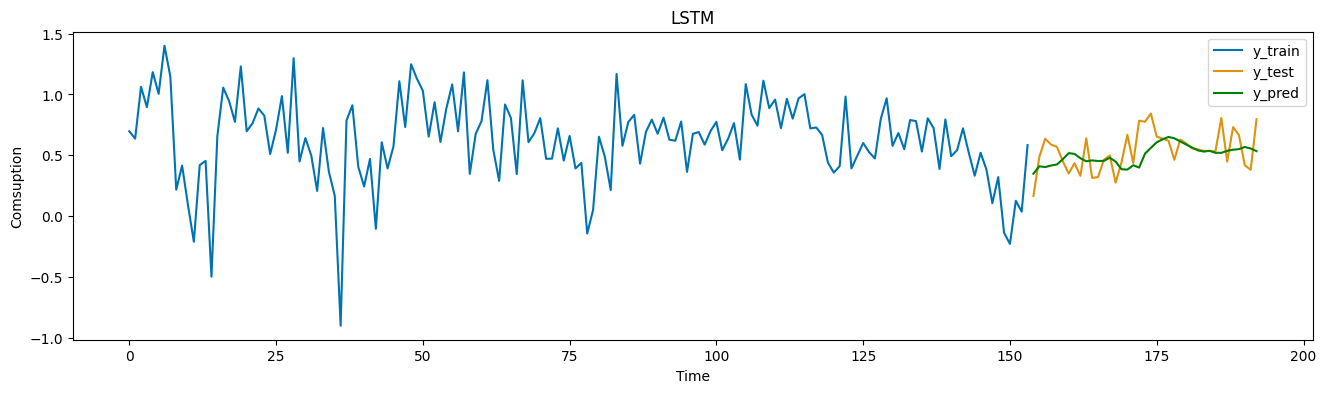

In [24]:
# Valores de treino na escala original
y_train_original = scaler.inverse_transform(np.hstack([np.zeros((y_train.shape[0], scaled_data.shape[1] - 1)), y_train.reshape(-1, 1)]))[:, -1]

# Criação do eixo temporal
train_time = np.arange(len(y_train_original))
test_time = np.arange(len(y_train_original), len(y_train_original) + len(y_test_original))

# Gráfico
plt.figure(figsize=(16, 4))

# Valores de treino
plt.plot(train_time, y_train_original, label="y_train", color='#0073b3')

# Valores reais (test set)
plt.plot(test_time, y_test_original, label="y_test", color='#dd930e')

# Valores preditos
plt.plot(test_time, y_pred_original, label="y_pred", color='green')

# Configuração do gráfico
plt.title("LSTM")
plt.xlabel("Time")
plt.ylabel("Comsuption")
plt.legend()
plt.grid(False)

# Exibir o gráfico
plt.show()